In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf

import warnings
warnings.filterwarnings('ignore')

In [2]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i+look_back, 0])
	return np.array(dataX), np.array(dataY)

def plot_history(history):
    mse = history.history['loss']
    val_mse = history.history['val_loss']
    x = range(1, len(mse) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, mse, 'b', label='Training MSE')
    plt.plot(x, val_mse, 'r', label='Validation MSE')
    plt.title('Training and validation LOSS - MSE')
    plt.xlabel('epoca')
    plt.ylabel('mse')
    plt.legend()
    
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-actual)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})    

In [3]:
df_temporal = pd.read_csv("base_ex4.csv");
df_temporal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   valor   389 non-null    int64
dtypes: int64(1)
memory usage: 3.2 KB


# Previsão por Dias

In [52]:
X = np.array(df_temporal.valor)
X = X.astype('float32').reshape(-1,1)

In [53]:
scaler = MinMaxScaler()
#scaler = StandardScaler()
X = scaler.fit_transform(X)

In [54]:
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size

train = X[0:train_size,:]
test =  X[train_size:len(X),:]

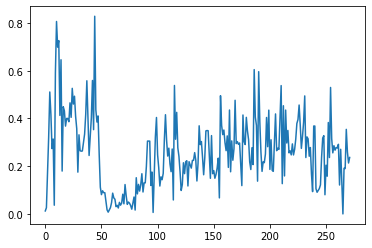

In [55]:
plt.plot(train)

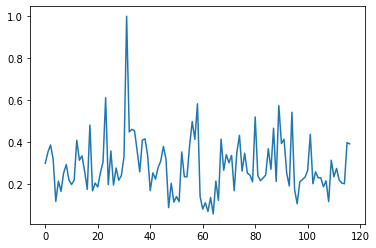

In [56]:
plt.plot(test)

In [38]:
best = 0
best_mse = np.Infinity
for n in range(1, 21, 1):
    look_back = n
    X_train, y_train = create_dataset(train, look_back)
    X_test, y_test = create_dataset(test, look_back)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    model = Sequential()
    model.add(LSTM(128, input_shape=(look_back, 1), dropout=0.2))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=1, verbose=0)
    mse = min(history.history['val_loss'])
    if best_mse > mse:
        best_mse = mse
        best = n
    print(f"look back {n} - {mse} | best {best} - {best_mse}")    

look back 1 - 0.017070071771740913 | best 1 - 0.017070071771740913
look back 2 - 0.016639018431305885 | best 2 - 0.016639018431305885
look back 3 - 0.016863368451595306 | best 2 - 0.016639018431305885
look back 4 - 0.016979621723294258 | best 2 - 0.016639018431305885
look back 5 - 0.017115339636802673 | best 2 - 0.016639018431305885
look back 6 - 0.01716712862253189 | best 2 - 0.016639018431305885
look back 7 - 0.01736806146800518 | best 2 - 0.016639018431305885
look back 8 - 0.01771896705031395 | best 2 - 0.016639018431305885
look back 9 - 0.017711961641907692 | best 2 - 0.016639018431305885
look back 10 - 0.0179582592099905 | best 2 - 0.016639018431305885
look back 11 - 0.01799069344997406 | best 2 - 0.016639018431305885
look back 12 - 0.018386295065283775 | best 2 - 0.016639018431305885
look back 13 - 0.017905287444591522 | best 2 - 0.016639018431305885
look back 14 - 0.018177436664700508 | best 2 - 0.016639018431305885
look back 15 - 0.018505487591028214 | best 2 - 0.01663901843130

In [57]:
# quantidade de atrasos
look_back = 2

X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

In [58]:
# reshape da entrada para ser [amostras, time steps, caracteristicas]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Modelo LSTM

In [59]:
model = Sequential()
model.add(LSTM(128, input_shape=(look_back, 1), dropout=0.2))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [60]:
checkpointer = ModelCheckpoint(filepath='./modelo_lstm_ex4.hdf5', verbose=1, save_best_only=True, monitor='val_loss')

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=1, callbacks=[checkpointer])

Epoch 1/50
262/269 [============================>.] - ETA: 0s - loss: 0.0197
Epoch 00001: val_loss improved from inf to 0.01836, saving model to .\modelo_lstm_ex4.hdf5
269/269 [==============================] - 1s 2ms/step - loss: 0.0199 - val_loss: 0.0184
Epoch 2/50
264/269 [============================>.] - ETA: 0s - loss: 0.0178
Epoch 00002: val_loss did not improve from 0.01836
269/269 [==============================] - 0s 1ms/step - loss: 0.0176 - val_loss: 0.0185
Epoch 3/50
238/269 [=========================>....] - ETA: 0s - loss: 0.0182
Epoch 00003: val_loss improved from 0.01836 to 0.01663, saving model to .\modelo_lstm_ex4.hdf5
269/269 [==============================] - 0s 1ms/step - loss: 0.0190 - val_loss: 0.0166
Epoch 4/50
256/269 [===========================>..] - ETA: 0s - loss: 0.0183
Epoch 00004: val_loss did not improve from 0.01663
269/269 [==============================] - 0s 1ms/step - loss: 0.0183 - val_loss: 0.0167
Epoch 5/50
241/269 [=========================>..

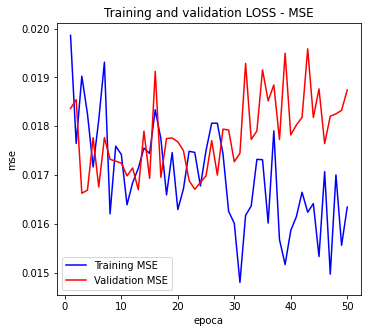

In [61]:
plot_history(history)

In [62]:
model = load_model("./modelo_lstm_ex4.hdf5")

In [63]:
# Predições
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [64]:
# Faz a transformação inversa das predições
trainPredict = scaler.inverse_transform(trainPredict)
y_tr = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_te = scaler.inverse_transform([y_test])

In [65]:
# Calcula o RMSE
trainScore = math.sqrt(mean_squared_error(y_tr[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_te[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 493730.08 RMSE
Test Score: 518598.88 RMSE


In [66]:
# Prepara o vetor para plotagem do conjunto de treinamento
trainPredictPlot = np.empty_like(X)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back-1:len(trainPredict)+look_back-1, :] = trainPredict

In [67]:
# Prepara o vetor para plotagem do conjunto das predições
testPredictPlot = np.empty_like(X)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(X)-2, :] = testPredict

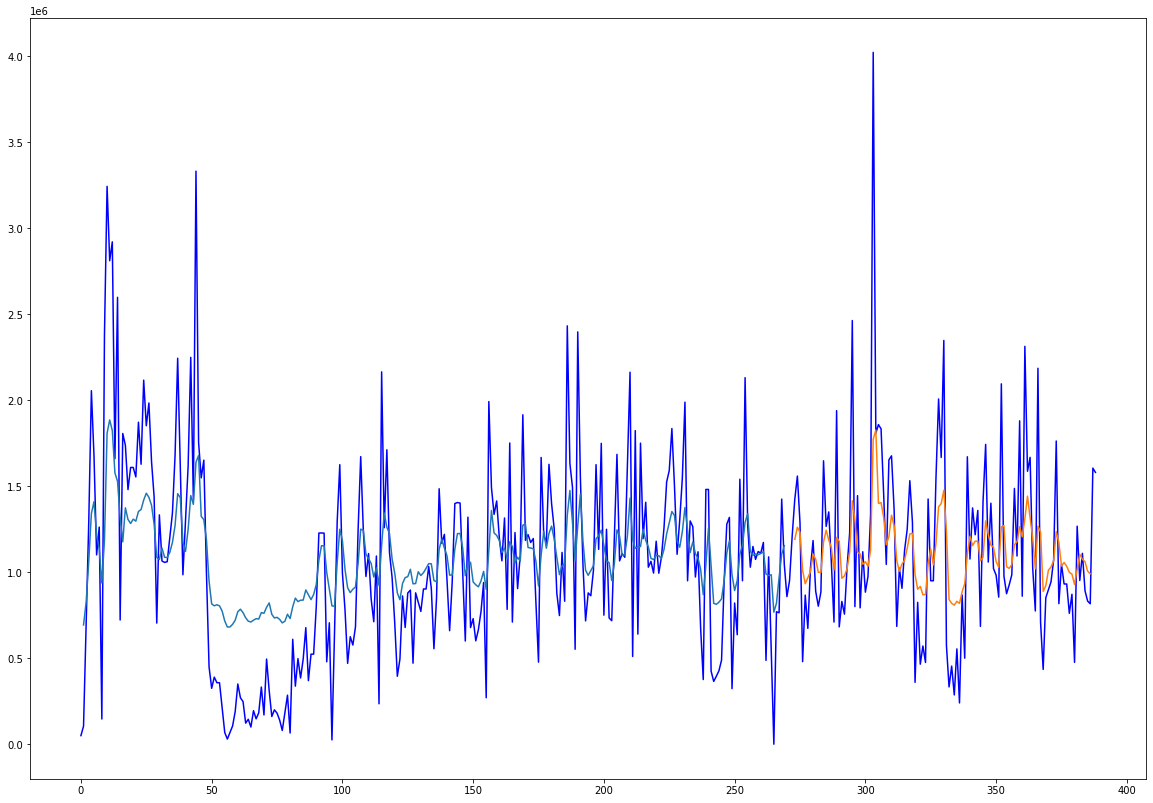

In [68]:
# Plota o dataset, as predições sobre o conjunto de treinamento e teste
plt.figure(figsize=(20,14))
plt.plot(scaler.inverse_transform(X), color='b')
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [69]:
y_te = y_te.reshape(-1,1)
mean_absolute_percentage_error(testPredict, y_te)

0.3252468186291784